In [ ]:
import pandas as pd
import lightgbm as ltb
import numpy as np
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, roc_auc_score

from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)


In [2]:
dir_path = 'C:/Users/Edward/Documents/Appleolga/Final_pro/model2/'
# dir_path = 'C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/'

In [ ]:
#READING INITIAL TRAIN DATA
data_traff_train = pd.read_sas(dir_path +'train/hash_school_dpi_model_traff.sas7bdat')
data_train = pd.read_sas(dir_path + 'train/hash_school_dpi_model_fe.sas7bdat')

#READING INITIAL TEST DATA
data_traff_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_traff_test.sas7bdat')
data_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_fe_test.sas7bdat')
data_test2 = pd.read_sas(dir_path + 'test/hash_school_dpi_model_test.sas7bdat')

In [ ]:
# #DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

print(data_train.shape)
print(data_traff_train.shape)
data_traff_train = data_traff_train.drop_duplicates()
data_train = data_train.drop_duplicates()
print(data_train.shape)
print(data_traff_train.shape)

data_train = data_train.merge(data_traff_train, on = 'abon_id')
del data_traff_train

print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)
data_test = data_test.drop_duplicates()
data_test2 = data_test2.drop_duplicates()
data_traff_test = data_traff_test.drop_duplicates()
print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)

data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
del data_test2
del data_traff_test

data_train = data_train.astype('float32')
data_test = data_test.astype('float32')

In [3]:
# # # WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# # data_train.to_parquet((dir_path + 'train/data_train.parquet.gzip'),compression='gzip')
# # data_test.to_parquet((dir_path + 'test/data_test.parquet.gzip'),compression='gzip')

# # # READING INITIAL MERGED TRAIN AND TEST DATA FROM PARQUET
data_train = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip')

In [4]:
#CHECKING TRAFFIC VARIANCE

traffic_cols = ['traff_m5', 'traff_m4', 'traff_m3','traff_m2','traff_m1']
traff_var = pd.DataFrame(data = data_train[traffic_cols].var(), columns = ['traff_var'])
traff_var.style.format("{:.10}")

In [5]:
traffic_df_train = data_train[traffic_cols]
# traffic_df_test = data_test[traffic_cols]

In [6]:
traffic_df_train.describe()

traff_m5      traff_m4       traff_m3       traff_m2  \
count  250017.000000  2.500170e+05  250017.000000  250017.000000   
mean        4.606479  2.306247e+01       5.675734       5.794854   
std         9.954336  8.912633e+03      11.302563      11.190779   
min         0.000000  0.000000e+00       0.000000       0.004883   
25%         0.040245  1.183636e-01       0.188417       0.324519   
50%         0.990819  1.235726e+00       1.408146       1.584272   
75%         4.329662  5.041220e+00       5.450376       5.612601   
max      1025.197510  4.456472e+06     436.159088     277.037262   

            traff_m1  
count  250017.000000  
mean        5.936551  
std        11.974113  
min         0.000000  
25%         0.215108  
50%         1.473195  
75%         5.594456  
max       640.266663

In [7]:
traffic_df_train.sort_values(by = 'traff_m4', ascending = False)

traff_m5      traff_m4    traff_m3    traff_m2    traff_m1
index                                                               
219252   19.389360  4.456472e+06   12.937638   22.850140    5.037920
217018   32.776627  2.341316e+02  323.528503    7.150309   57.112225
225292  203.641739  1.974701e+02  142.643738  181.878891  112.523209
115912  147.485641  1.974000e+02    1.870279    0.976280    1.645507
209639   78.837807  1.673304e+02  136.827057   88.402878    0.000019
...            ...           ...         ...         ...         ...
214277    0.000000  0.000000e+00    0.000000    0.194597    0.000000
230279    0.000024  0.000000e+00    0.000000    0.103316    0.000613
73380     0.000000  0.000000e+00    0.002129    0.019230    0.005706
107370    0.000000  0.000000e+00    0.370100   15.418396   24.903795
250016    0.000000  0.000000e+00    0.000000    0.006286    0.067443

[250017 rows x 5 columns]

In [8]:
traffic_df_train = traffic_df_train.drop(219252)
traffic_df_train.describe()

traff_m5       traff_m4       traff_m3       traff_m2  \
count  250016.000000  250016.000000  250016.000000  250016.000000   
mean        4.606420       5.238247       5.675705       5.794785   
std         9.954314      10.567046      11.302574      11.190750   
min         0.000000       0.000000       0.000000       0.004883   
25%         0.040243       0.118362       0.188416       0.324515   
50%         0.990813       1.235701       1.408129       1.584247   
75%         4.329613       5.041162       5.450338       5.612582   
max      1025.197510     234.131577     436.159088     277.037262   

            traff_m1  
count  250016.000000  
mean        5.936554  
std        11.974136  
min         0.000000  
25%         0.215106  
50%         1.473194  
75%         5.594473  
max       640.266663

In [ ]:
traffic_df_train.describe().loc[['mean','25%', '50%', '75%']].plot()

In [ ]:
traffic_df_test.describe().loc[['mean','25%', '50%', '75%']].plot()

In [9]:
data_train = data_train.drop(219252)
print(data_train.shape)
del traffic_df_train

(250016, 911)


In [10]:
#FUNCTION TO FIND CATEGORICAL COLUMNS

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list

In [11]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

32
879


In [12]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [13]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [14]:
data_train_num_outliers_mask = mark_outliers(data_train[num_col_list])
data_train_num_info = df_info(data_train[num_col_list], data_train_num_outliers_mask)
del data_train_num_outliers_mask

100
200
300
400
500
600
700
800


In [15]:
# HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [16]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.4%}"})
data_train_num_info_style

In [17]:
X_train_full = data_train.drop('target', axis = 1)

y_train_full = data_train['target']

X_test_full = data_test.drop('target', axis = 1)

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))


f_importance_df = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

RMSE train: 7.554661, test: 8.655578
R^2 train: 0.595218, test: 0.446710


importance
traff_m1                                 158
traff_m5                                 103
traff_m4                                  48
non_accum_internet_vol_mea_mnt3           48
device_days_usage                         36
bs_succ_rate                              36
dpi_upload                                32
MV_Traf_4G_d_Mb                           32
loc_lon                                   28
non_accum_internet_vol_std_mnt1           27
non_accum_internet_vol_td_mnt3            26
traff_m3                                  25
non_accum_internet_vol_min_mnt3           24
device_price                              22
imei_mean_day_announced                   20
non_accum_internet_vol_min_mnt1           19
non_accum_internet_vol_mea_wk1            18
myvf_day_usage                            18
imei_mean_days_usage                      18
std_paym_6_month                          17
abon_part_td_mnt3                         16
MV_Traf_Cont_inc_s_Cnt                    16
non_accum_internet_vol_mea_mnt1           16
imei_mean_price                           14
MV_ap_innet_out_v                         14
non_accum_internet_vol_max_mnt3           14
non_accum_internet_vol_max_mnt1           13
non_accum_internet_vol_std_mnt3           13
dpi_download                              13
traff_m2                                  13
data_3g_tar_vol_std_mnt1                  12
data_3g_tar_vol_min_mnt1                  12
data_3g_tar_vol_td_mnt3                   12
data_3g_tar_vol_mea_wk1                   12
imei_max_price                            12
DNZ_DAYS_from_last_year5                  11
content_cnt_std_mnt3                      11
data_3g_dou_std_mnt3                      11
Balance_uah                               11
content_cnt_td_mnt3                       11
MV_Traf_3G_d_Mb                           10
dpi_events                                10
data_3g_tv_cnt_mea_mnt3                   10
data_3g_tv_cnt_td_mnt3                    10
voice_mts_out_nrest_partstd_mnt3          10
MV_ap_4G_d                                10
gprs_tar_vol_td_mnt3                       9
sms_in_cnt_std_mnt3                        9
content_cnt_mea_mnt3                       9
pay_avg_td_mnt3                            9
bs_drop_rate                               9
conn_in_uniq_cnt_td_mnt3                   9
MV_Traf_ACCA_out_v_Min                     9
MV_AP_total                                9
MV_Traf_2G_d_Mb                            9
max_paym_6_month                           9
bs_ovrl_OMO_CNT_M2                         9
imei_mean_long_days_usage                  9
voice_mts_out_nwork_partmea_mnt1           8
MV_Traf_innet_out_v_Min                    8
cnt_sms_category_microcred                 8
voice_mts_out_nrest_partmea_mnt3           8
voice_mts_out_drest_partmea_wk1            8
sms_in_cnt_std_mnt1                        8
sum_paym_6_month                           8
voice_mts_in_drest_part_std_mnt3           8
count_day_for_last_paym                    8
voice_mts_in_nwork_part_std_mnt1           8
last_paym                                  8
voice_mts_in_drest_part_mea_wk1            8
MV_dou_4G_d                                8
voice_mts_in_nrest_part_mea_wk1            8
voice_mts_out_dwork_partmax_mnt3           8
num_act_days_td_mnt3                       8
voice_in_life_part_td_mnt3                 8
DNZ_STD_days_closed_loan_year2             8
content_cnt_mea_mnt1                       8
gprs_tar_vol_mea_wk1                       8
all_cnt_std_mnt1                           8
loc_lat                                    8
clc_no_vas_roam_max_mnt1                   8
dpi_duration                               8
com_num_part_td_mnt3                       8
conn_in_uniq_cnt_std_mnt1                  8
voice_mts_out_nwork_partmax_mnt3           7
content_cnt_max_mnt3                       7
voice_mts_in_nrest_part_mea_mnt3           7
bs_ovrl_OMO_CNT_M3                         7
conn_in_uniq_cnt_max_mnt3    

In [ ]:
# VISUALIZING TRAFFIC FEATURES
# traffic is almost completely revolves around zero values. 
# there are big tails. outliers? 

data_train[traffic_cols].plot.box()

In [18]:
# let's see how traffic values are disperces and how quickly they rich the maximum values

data_train[traffic_cols].describe(percentiles=[0.1, 0.25, 0.5, 0.75, .9, 0.95, 0.96, 0.97, 0.98, 0.99])

traff_m5       traff_m4       traff_m3       traff_m2  \
count  250016.000000  250016.000000  250016.000000  250016.000000   
mean        4.606420       5.238247       5.675705       5.794785   
std         9.954314      10.567046      11.302574      11.190750   
min         0.000000       0.000000       0.000000       0.004883   
10%         0.000000       0.000000       0.000433       0.050532   
25%         0.040243       0.118362       0.188416       0.324515   
50%         0.990813       1.235701       1.408129       1.584247   
75%         4.329613       5.041162       5.450338       5.612582   
90%        12.978082      14.881179      16.043688      16.153775   
95%        22.645217      25.595340      27.813591      28.066110   
96%        26.147950      29.662685      31.889837      32.068639   
97%        30.727420      34.619560      37.172500      37.310408   
98%        37.428965      41.671082      44.620659      44.346900   
99%        48.739244      53.382152      56.622750      56.169255   
max      1025.197510     234.131577     436.159088     277.037262   

            traff_m1  
count  250016.000000  
mean        5.936554  
std        11.974136  
min         0.000000  
10%         0.005244  
25%         0.215106  
50%         1.473194  
75%         5.594473  
90%        16.610559  
95%        29.384723  
96%        33.797472  
97%        39.654549  
98%        47.433544  
99%        60.308335  
max       640.266663

In [19]:
# let's see how the records with outlier traffic values look like

traff_99p_mean = data_train[traffic_cols].describe(percentiles=[0.99]).loc['99%'].mean()
data_train[traffic_cols][data_train[traffic_cols].applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                                  sort_values(by=['traff_m1']).head(10)

traff_m5    traff_m4   traff_m3   traff_m2  traff_m1
index                                                         
242165    0.000000   29.153332  68.455406  20.952452       0.0
222354   67.760376   30.804821  33.356075  26.090715       0.0
222359   57.468796   18.080578  14.142037  11.276637       0.0
209777   59.457302   39.793510  27.803486   4.704026       0.0
235583    0.000000   54.932251  62.511463   8.190764       0.0
241752    0.000000   16.577456  69.185158  39.499989       0.0
241684    0.000000   59.654133  37.158142  23.060980       0.0
164193  114.132408  106.867149  69.002144   6.070008       0.0
241678    0.000000    0.000000   0.000000  68.574120       0.0
235842    0.000000   12.521206  57.421375   0.127437       0.0

In [20]:
data_train[traffic_cols][data_train[traffic_cols].applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                                  sort_values(by=['traff_m2']).head(10)

traff_m5    traff_m4    traff_m3  traff_m2   traff_m1
index                                                          
232131   49.006203   55.211899    0.011743  0.004989   0.000000
225096    4.598783    4.080782  436.159088  0.005361   7.692547
185717   44.958469   87.742302   72.721352  0.005390  93.529198
194266    0.000570   82.346832   55.036690  0.005590   0.000411
202681   81.528839   29.038713    0.005891  0.006283   0.001251
203401  119.626480  151.777115  189.712906  0.006939  84.945328
206411   25.542538   34.025978   98.745987  0.007050   0.000077
212959   64.616203   62.002060   30.743694  0.007691   0.000036
221404   61.792042   17.815115   29.216694  0.007988   0.000000
191198    0.000000    0.000000    0.000000  0.008274  65.790398

In [21]:
data_train[traffic_cols][data_train[traffic_cols].applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                                  sort_values(by=['traff_m2']).tail(10)

traff_m5    traff_m4    traff_m3    traff_m2    traff_m1
index                                                             
232603    0.000000   35.786503  117.395821  147.575745  166.207321
243663    0.000000    0.000000   78.325516  148.597122  146.413528
236665    0.000000    0.000000    3.242211  155.292877  154.723633
228059    0.000000    0.000000  136.842194  157.624771   97.705162
170314  123.389137  124.495270  116.365601  163.058517  122.242088
210518   54.617031   71.973145   50.987206  163.250839  184.453964
223648    0.000000    0.000000   75.851524  179.702118  131.413086
225292  203.641739  197.470062  142.643738  181.878891  112.523209
220838   26.512714   15.688222  217.478241  252.568634  249.768799
234386    0.000000    6.448248   26.752644  277.037262  640.266663

In [ ]:
# There is big dispersion in traffic values. Sometimes it looks like new clients with zero traffic in m5 and big traffic in m1. 
# Sometimes these are the clients that are leaving (big traffic 5 months ago and 0 traffic in m1) and sometimes 
# the dispersion is big without any visible pattern

In [ ]:
# # CALCULATION OF TRAFFIC VARIANCE AND TRAFFIC COLS LIN.REGR. SLOPE FOR EACH OBSERVATION

data_train = data_train.assign(var = data_train[traffic_cols].apply(lambda x: x.var(), axis=1))
data_train = data_train.assign(var_quant = pd.qcut(data_train['var'], 10,labels = False))

data_test = data_test.assign(var = data_test[traffic_cols].apply(lambda x: x.var(), axis=1))
data_test = data_test.assign(var_quant = pd.qcut(data_test['var'], 10,labels = False))

enum = np.arange(1, len(traffic_cols)+1, 1)

data_train = data_train.assign(slope_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_test = data_test.assign(slope_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

# data_train = data_train.assign(interc_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

# data_test = data_test.assign(interc_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

In [22]:
# # WRITING TRAIN AND TEST DATA WITH VARIANCE, QUANTILES AND SLOPE TO PARQUET

# data_train.to_parquet((dir_path + 'train/data_train_with_var.parquet.gzip'),compression='gzip')
# data_test.to_parquet((dir_path + 'test/data_test_with_var.parquet.gzip'),compression='gzip')


# # READING TRAIN AND TEST DATA WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train = pd.read_parquet(dir_path + 'train/data_train_with_var.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test_with_var.parquet.gzip')


In [ ]:
data_train[['slope_traff', 'var']].describe(percentiles=np.arange(0.1, 1, 0.1)).style.format('{:.4f}')

In [ ]:
data_train['slope_traff'].plot.hist(bins = 400,
                                    xlim = (-10,10),
                                    xticks = range(-10,10, 1),
                                    figsize = (9,3))


In [23]:
X_train_full = data_train.drop('target', axis = 1)

y_train_full = data_train['target']

X_test_full = data_test.drop('target', axis = 1)

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))


f_importance_df = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

RMSE train: 7.544425, test: 8.651764
R^2 train: 0.596314, test: 0.447198


importance
traff_m1                                 138
traff_m5                                 106
traff_m4                                  52
non_accum_internet_vol_mea_mnt3           46
var                                       41
dpi_upload                                37
bs_succ_rate                              32
device_days_usage                         31
non_accum_internet_vol_min_mnt3           29
imei_mean_day_announced                   28
MV_Traf_4G_d_Mb                           26
traff_m3                                  26
slope_traff                               22
loc_lon                                   22
non_accum_internet_vol_td_mnt3            21
non_accum_internet_vol_std_mnt3           21
device_price                              21
non_accum_internet_vol_std_mnt1           21
myvf_day_usage                            21
sum_paym_6_month                          17
non_accum_internet_vol_mea_wk1            17
non_accum_internet_vol_mea_mnt1           16
data_3g_dou_std_mnt3                      15
imei_mean_price                           14
traff_m2                                  14
gprs_tar_vol_mea_wk1                      13
days_of_end_last_ppm                      13
dpi_download                              13
MV_AP_total                               13
MV_ap_innet_out_v                         13
imei_mean_days_usage                      13
dpi_events                                13
bs_ovrl_OMO_CNT_M2                        12
data_3g_tar_vol_mea_mnt3                  12
std_paym_6_month                          12
voice_in_tar_dur_td_mnt3                  12
Balance_uah                               11
non_accum_internet_vol_max_mnt1           11
DNZ_DAYS_from_last_year5                  11
dpi_duration                              11
voice_mts_out_dwork_partstd_mnt1          11
content_cnt_std_mnt3                      11
data_3g_tar_vol_td_mnt3                   11
data_3g_tv_cnt_td_mnt3                    11
data_3g_tv_cnt_std_mnt3                   11
voice_in_kievstar_part_td_mnt3            11
MV_Traf_ACCA_out_v_Min                    10
data_3g_tar_vol_std_mnt1                  10
imei_max_price                            10
imei_mean_long_days_usage                 10
last_paym                                 10
voice_mts_out_nwork_partmea_mnt1          10
max_paym_6_month                          10
MV_ap_4G_d                                10
loc_lat                                   10
gprs_tar_vol_td_mnt3                      10
voice_in_short_part_td_mnt3               10
cnt_sms_category_microcred                 9
voice_mts_in_nrest_part_mea_wk1            9
voice_in_cmpttrs_avg_durmax_mnt3           9
MV_Traf_3G_d_Mb                            9
abon_part_td_mnt3                          9
MV_Traf_2G_d_Mb                            9
clc_no_vas_roam_td_mnt3                    9
content_cnt_td_mnt3                        9
content_cnt_mea_mnt1                       9
voice_mts_out_nrest_partmea_mnt3           8
data_3g_tv_cnt_mea_wk1                     8
DNZ_STD_days_closed_loan_year2             8
all_cnt_std_mnt3                           8
all_cnt_min_mnt3                           8
all_cnt_std_mnt1                           8
com_num_part_td_mnt3                       8
com_num_part_std_mnt3                      8
data_3g_tar_vol_min_mnt1                   8
pay_avg_mea_mnt1                           8
voice_out_short_part_td_mnt3               8
data_3g_tar_vol_max_mnt1                   8
voice_in_fix_tar_dur_max_mnt3              8
data_3g_tar_vol_mea_wk1                    8
voice_in_mts_avg_dur_max_mnt3              8
ks_num_part_td_mnt3                        8
voice_mts_out_dwork_parttd_mnt3            8
voice_mts_in_dwork_part_mea_wk1            8
non_accum_internet_vol_min_mnt1            8
data_3g_dou_td_mnt3                        8
abon_id                                    8
cnt_sms_category_online_auth               8
bs_drop_call_rate            

In [ ]:
# model perfomance has not improved, but new features - var and slope_traff are among the 15 most important now

In [24]:
# let's filter out records with big traffic variance and see how the model performs
var_quant_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
var_quant_error_df = pd.DataFrame(index= var_quant_list[::-1], columns=['RMSE_train', 'RMSE_test', 'RMSE_by_quant'])

while len(var_quant_list):

    X_train_full = data_train[data_train['var_quant'].isin(var_quant_list)].drop('target', axis = 1)

    print(X_train_full.shape)

    y_train_full = data_train[data_train['var_quant'].isin(var_quant_list)]['target']

    X_test_full = data_test[data_test['var_quant'].isin(var_quant_list)].drop('target', axis = 1)

    y_test_full = data_test[data_test['var_quant'].isin(var_quant_list)]['target']
    
    X_train_quant = data_train[data_train['var_quant'] == max(var_quant_list)].drop('target', axis = 1)

    y_train_quant = data_train[data_train['var_quant'] == max(var_quant_list)]['target']

    model = ltb.LGBMRegressor(objective ='regression',
                              random_state = 0)


    model.fit(X_train_full,y_train_full)

    y_train_pred = model.predict(X_train_full)
    y_test_pred = model.predict(X_test_full)
    y_pred_by_quant = model.predict(X_train_quant)

    var_quant_error_df.loc[max(var_quant_list)] = [mean_squared_error(y_train_full, y_train_pred, squared = False),
                                                   mean_squared_error(y_test_full, y_test_pred, squared = False),
                                                   mean_squared_error(y_train_quant, y_pred_by_quant, squared = False)]
    del var_quant_list[-1]

(250016, 913)
(225014, 913)
(200013, 913)
(175011, 913)
(150010, 913)
(125008, 913)
(100007, 913)
(75005, 913)
(50004, 913)
(25002, 913)


In [ ]:
var_quant_error_df['RMSE_by_quant'].plot(kind='bar')

In [ ]:
# most of the error lies in the records with biggest traffic variance per record. 
# Starting from 70th and lower variance quantiles RMSE drops below 7
var_quant_error_df

In [25]:
# let's find and look at the traffic linregress line slope outliers 

from scipy import stats

data_train = data_train.assign(z_score_slope = scipy.stats.zscore(data_train['slope_traff']))
                                                                
data_train = data_train.assign(big_slope = data_train['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 3) else 0))

data_test = data_test.assign(z_score_slope = scipy.stats.zscore(data_test['slope_traff']))
                                                                
data_test = data_test.assign(big_slope = data_test['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 3) else 0))

In [26]:
data_train.groupby('big_slope')['abon_id'].count()

big_slope
0    244119
1      5897
Name: abon_id, dtype: int64

In [27]:
# let's see how model performs for regular slope and outlier slope records
big_slope_list = [0, 1]
big_slope_error_df = pd.DataFrame(index= big_slope_list, columns=['RMSE_train', 'RMSE_test', 'RMSE_by_bs'])

while len(big_slope_list):

    X_train_full = data_train[data_train['big_slope'].isin(big_slope_list)].drop('target', axis = 1)

    print(X_train_full.shape)

    y_train_full = data_train[data_train['big_slope'].isin(big_slope_list)]['target']

    X_test_full = data_test[data_test['big_slope'].isin(big_slope_list)].drop('target', axis = 1)

    y_test_full = data_test[data_test['big_slope'].isin(big_slope_list)]['target']
    
    X_train_bs = data_train[data_train['big_slope'] == max(big_slope_list)].drop('target', axis = 1)

    y_train_bs = data_train[data_train['big_slope'] == max(big_slope_list)]['target']

    model = ltb.LGBMRegressor(objective ='regression',
                              random_state = 0)


    model.fit(X_train_full,y_train_full)

    y_train_pred = model.predict(X_train_full)
    y_test_pred = model.predict(X_test_full)
    y_pred_by_bs = model.predict(X_train_bs)

    big_slope_error_df.loc[max(big_slope_list)] = [mean_squared_error(y_train_full, y_train_pred, squared = False),
                                                   mean_squared_error(y_test_full, y_test_pred, squared = False),
                                                   mean_squared_error(y_train_bs, y_pred_by_bs, squared = False)]
    del big_slope_list[-1]

(250016, 915)
(244119, 915)


In [ ]:
# so, most of the prediction error lies in the records lies in the records with big variance, 
# with the primary focus on extremely big linregress line slope samples
big_slope_error_df

In [38]:
# Let's see which features might predict big slope feature 

X_train_full = data_train.drop(traffic_cols + ['target', 'var', 'var_quant', 'slope_traff', 'z_score_slope', 'big_slope'], 
                               axis = 1)

y_train_full = data_train['big_slope']


model = ltb.LGBMClassifier(objective ='binary',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_full, y_train_pred)

0.7646133123124413

In [39]:
big_slope_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
big_slope_features = big_slope_features[big_slope_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)

big_slope_features = big_slope_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = big_slope_features['importance'].cumsum())
big_slope_features['cum_sum']  = big_slope_features['cum_sum']/big_slope_features['importance'].sum()

print(big_slope_features.shape)
big_slope_features.style.format({'cum_sum': "{:.2%}"})

(625, 2)


In [40]:
# We see that there are some duplicate features, which are stat metrics of the same variable. 
# Let's filter out the ones, that have lower importance and keep only most important ones

data_descr = pd.read_csv((dir_path + 'data_descr.csv'), names=['feature', 'descr'])

big_slope_features = pd.merge(big_slope_features, data_descr, how='left', left_index=True, right_on='feature')

big_slope_features.loc[big_slope_features['descr'].isna(), 
                        'descr'] = big_slope_features.loc[big_slope_features['descr'].isna(), 'feature']

big_slope_features = big_slope_features.assign(feature_clear = big_slope_features['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

big_slope_features['feature_clear'] = big_slope_features.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))


In [41]:
slope_cols_to_use = list(big_slope_features.groupby('feature_clear')['feature'].max('importance').values)

print(len(slope_cols_to_use))
# sorted(slope_cols_to_use)

221


In [32]:
big_slope_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
big_slope_features = big_slope_features[big_slope_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)

In [33]:
print(big_slope_features.shape)
big_slope_features = big_slope_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = big_slope_features['importance'].cumsum())
big_slope_features['cum_sum']  = big_slope_features['cum_sum']/big_slope_features['importance'].sum()
big_slope_features.style.format({'cum_sum': "{:.2%}"})

(625, 1)


In [34]:
#let;s filter out duplicate stat metric features for features important for general model

f_importance_df[f_importance_df['importance'] > 0].sort_values(by='importance')

f_importance_df = pd.merge(f_importance_df, data_descr, how='left', left_index=True, right_on='feature')

f_importance_df.loc[f_importance_df['descr'].isna(),'descr'] = f_importance_df.loc[f_importance_df['descr'].isna(), 'feature']

f_importance_df = f_importance_df.assign(feature_clear = f_importance_df['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

f_importance_df['feature_clear'] = f_importance_df.feature_clear.apply(lambda x: re.sub(escaped_expression, '', str(x)))

In [35]:
traff_cols_to_use = list(f_importance_df.groupby('feature_clear')['feature'].max('importance').values)

print(len(traff_cols_to_use))

322


In [42]:
#let's combine two feature lists to explore important feature further 

cols_to_use = traff_cols_to_use + slope_cols_to_use
cols_to_use = set(cols_to_use)
len(cols_to_use)

325

In [43]:
# Columns important for ppredicting big slope
differences = list(set(slope_cols_to_use)-set(traff_cols_to_use))
differences

['device_type_smartphone', 'device_has_lte', 'sms_roam_clc_mea_wk1']

In [ ]:
# non_accum_internet_vol_td_mnt3 seems to be one of the most importnant features alongside traffic ones. 
# Let's explore it

In [ ]:
data_train['non_accum_internet_vol_td_mnt3'].describe()

In [44]:
#Let's create logariphmic bins in order to be able to compare it to the target

symlog = data_train['non_accum_internet_vol_td_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_train = data_train.assign(non_accum_internet_vol_td_mnt3_log = symlog)

symlog = data_test['non_accum_internet_vol_td_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_test = data_test.assign(non_accum_internet_vol_td_mnt3_log = symlog)

data_train = data_train.assign(non_accum_internet_vol_td_mnt3_log_bins = pd.cut(data_train['non_accum_internet_vol_td_mnt3_log'], 
                                                                                bins=range(-19, 19)))

data_test = data_test.assign(non_accum_internet_vol_td_mnt3_log_bins = pd.cut(data_test['non_accum_internet_vol_td_mnt3_log'], 
                                                                                bins=range(-19, 19)))

del symlog

In [136]:
data_train = data_train.assign(big_var = data_train.apply(lambda x: 0 if (x['var_quant'] < 8) else 1, axis=1))
data_test = data_test.assign(big_var = data_test.apply(lambda x: 0 if (x['var_quant'] < 8) else 1, axis=1))

In [47]:
 def ratio_diagram(df, values_col, index_col, columns_cols, comparison_names, agg_func = 'count') :
        
    pivot_df = pd.pivot_table(df, 
                              values=values_col,
                              index=index_col,
                              columns=columns_cols, 
                              aggfunc=agg_func)
    
    pivot_df.columns = comparison_names
    pivot_df = pivot_df.assign(ratio = pivot_df[comparison_names[1]]/pivot_df[comparison_names[0]])


    pivot_df.sort_values(by = 'ratio', ascending = False)

    ax1 = pivot_df.loc[:, comparison_names].plot(kind = 'bar',
                                                 figsize = (10,5),
                                                 rot = 90,
                                                 sharex = True)


    ax1 = pivot_df['ratio'].plot(secondary_y=True,
                                 colormap = 'ocean',
                                 rot = 90,
                                 legend = True,
                                 sharex = True);
    
    plt.show()
    
    return pivot_df
    
    

In [69]:
ratio_df

small_var  big_var       ratio
non_accum_internet_vol_td_mnt3_log_bins                                
(-19, -18]                                       0        1         inf
(-18, -17]                                       0        2         inf
(-17, -16]                                       0       60         inf
(-16, -15]                                       0      802         inf
(-15, -14]                                      12     3193  266.083333
(-14, -13]                                     795     6285    7.905660
(-13, -12]                                    6878     5469    0.795144
(-12, -11]                                   13575     3089    0.227551
(-11, -10]                                   16596     1674    0.100868
(-10, -9]                                    15670      926    0.059094
(-9, -8]                                     12722      461    0.036236
(-8, -7]                                      9060      233    0.025717
(-7, -6]                                      6026      121    0.020080
(-6, -5]                                      3862       51    0.013206
(-5, -4]                                      2465       30    0.012170
(-4, -3]                                      1744       17    0.009748
(-3, -2]                                      1290       18    0.013953
(-2, -1]                                       908       17    0.018722
(-1, 0]                                       1494       92    0.061580
(0, 1]                                        1041       15    0.014409
(1, 2]                                        1668       16    0.009592
(2, 3]                                        1588       16    0.010076
(3, 4]                                        2243       25    0.011146
(4, 5]                                        3129       31    0.009907
(5, 6]                                        4423       64    0.014470
(6, 7]                                        6398      140    0.021882
(7, 8]                                        9780      231    0.023620
(8, 9]                                       13612      500    0.036732
(9, 10]                                      17188      926    0.053875
(10, 11]                                     18779     1713    0.091219
(11, 12]                                     16427     3273    0.199245
(12, 13]                                      9209     6100    0.662395
(13, 14]                                      1418     8201    5.783498
(14, 15]                                        13     4771  367.000000
(15, 16]                                         0     1349         inf
(16, 17]                                         0       89         inf
(17, 18]                                         0        1         inf

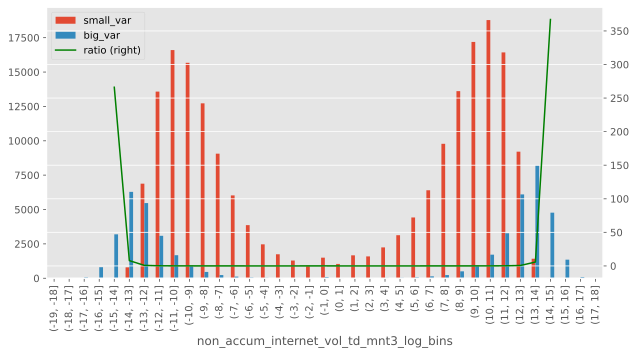

In [48]:
# For big 'non_accum_internet_vol_td_mnt3' values there are considerably more records with big traffic variance, 
# than with small variance

ratio_df = ratio_diagram(data_train, 
                         ['abon_id'], 
                         ['non_accum_internet_vol_td_mnt3_log_bins'], 
                         ['big_var'], 
                         ['small_var', 'big_var'])

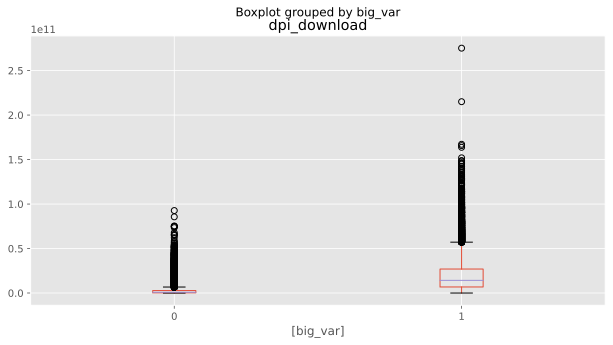

In [49]:
#dpi_download value for bid variance records is coonsiderably bigger and much more spred out
# while for small variance it is concentrated around zero values
data_train.boxplot(column='dpi_download', by=['big_var'])

In [50]:
#FUNCTION TO FIND CATEGORICAL COLUMNS
def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list

In [51]:
cat_num_col_list = find_cat_cols(data_train[cols_to_use])
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

15
310


In [52]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [53]:
data_train_num = data_train[num_col_list]
data_test_num = data_test[num_col_list]
data_train_num_outliers_mask = mark_outliers(data_train_num)

100
200
300


In [54]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [55]:
data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
del data_train_num_outliers_mask

In [ ]:
#let's see how the pre-selected features are correlated with the target
data_train_num_corr = data_train[num_col_list + ['target']].corr()

In [140]:
# # WRITING AND READING DATA_TRAIN TARGET CORRELATION DF TO PARQUET

# data_train_num_corr.to_parquet((dir_path + 'data_train_num_corr2.parquet.gzip'),compression='gzip')

data_train_num_corr = pd.read_parquet(dir_path +'data_train_num_corr2.parquet.gzip')


In [57]:
# ADDING TARGET CORR TO THE INFO DF
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)


In [58]:
# HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [60]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = 'target', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.4%}",
                                                        'target': "{:.2f}"})
data_train_num_info_style

In [61]:
data_train_num_info['target'].describe()

count    298.000000
mean       0.041060
std        0.124599
min       -0.260931
25%       -0.003321
50%        0.006690
75%        0.052309
max        0.667660
Name: target, dtype: float64

In [66]:
print('low target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() < 0.2].shape[0])


#PRINTING INFO DF FOR LOW TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() < 0.2].\
                            sort_values(by = 'col', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.4f}"})
data_train_num_info_style

low target corr features number:
277


In [64]:
print('high target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() >= 0.2].shape[0])

#PRINTING INFO DF FOR HIGH TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() >= 0.2].\
                            sort_values(by = '%nans', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

high target corr features number:
21


In [67]:
#CHOOSING THE FEATURES WITH AT LEAST 0.2 CORRELATION COEFF WITH THE TARGET
# AND LESS THAN 60% OF MISSINGS

num_cols_to_use = data_train_num_info[(data_train_num_info['target'].abs() >= 0.2) &\
                                      (data_train_num_info['target'].abs() < 1) &\
                                      (data_train_num_info['%nans'] < 0.6)]['col'].to_list()
len(num_cols_to_use)

19

In [68]:
sorted(num_cols_to_use)

['MV_AP_total',
 'MV_ARPU',
 'MV_Traf_2G_d_Mb',
 'MV_Traf_3G_d_Mb',
 'MV_Traf_4G_d_Mb',
 'MV_ap_4G_d',
 'MV_ap_innet_out_v',
 'dpi_day_cnt',
 'dpi_download',
 'dpi_duration',
 'dpi_events',
 'dpi_upload',
 'slope_traff',
 'traff_m1',
 'traff_m2',
 'traff_m3',
 'traff_m4',
 'traff_m5',
 'var_quant']

Text(0.5, 1.0, 'small_var')

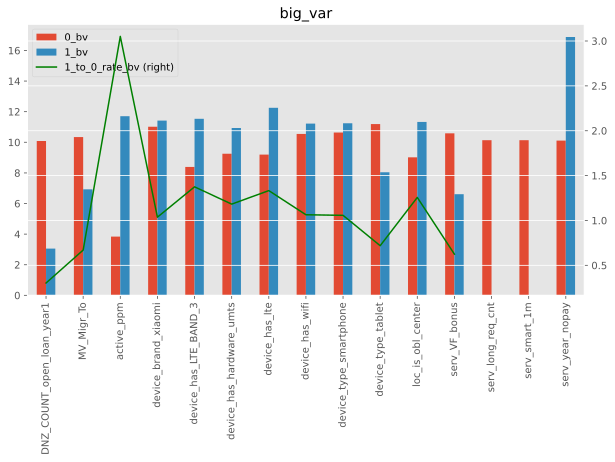

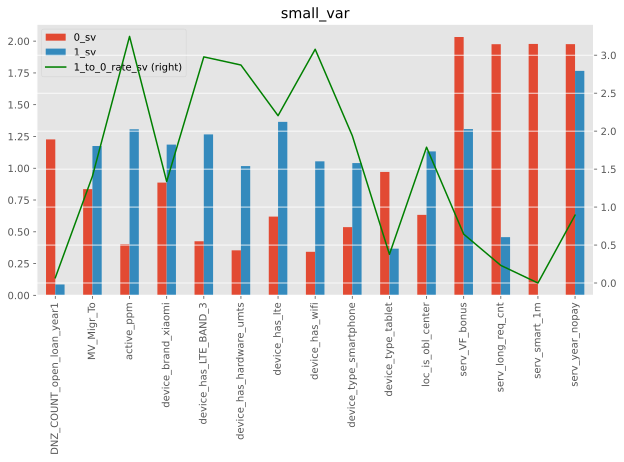

In [108]:
# VISUALZING TARGET DIFFERENCE RATE FOR CATEGORICAL COLUMNS

target_by_cat_cols = pd.DataFrame(index=cat_col_list, 
                                  columns=['0_bv', '1_bv', '1_to_0_rate_bv','0_sv', '1_sv', '1_to_0_rate_sv'])

for col in cat_col_list:
    temp = data_train[data_train['var_quant'] > 7].pivot_table(columns=col,
                                                               values='target', 
                                                               aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_bv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_bv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_bv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = np.nan
        
    temp = data_train[data_train['var_quant'] <= 7].pivot_table(columns=col,
                                                                values='target', 
                                                                aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_sv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_sv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_sv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = np.nan


ax1 = target_by_cat_cols.sort_index().loc[:, ['0_bv', '1_bv']].plot(kind = 'bar',
                                                                       figsize = (10,5),
                                                                       rot = 90,
                                                                       sharex = True)


ax1 = target_by_cat_cols.sort_index()['1_to_0_rate_bv'].plot(secondary_y=True,
                                                                colormap = 'ocean',
                                                                rot = 90, 
                                                                legend = True,
                                                                sharex = True);

ax1.set_title('big_var')
    
ax2 = target_by_cat_cols.sort_index().loc[:, ['0_sv', '1_sv']].plot(kind = 'bar',
                                                                    figsize = (10,5),
                                                                    rot = 90,
                                                                    sharex = True);

ax2 = target_by_cat_cols.sort_index()['1_to_0_rate_sv'].plot(secondary_y=True,
                                                             colormap = 'ocean',
                                                             rot = 90,
                                                             legend = True,
                                                             sharex = True);

ax2.set_title('small_var')

In [109]:
target_by_cat_cols.sort_values(by='1_to_0_rate_bv')

0_bv       1_bv 1_to_0_rate_bv      0_sv  \
DNZ_COUNT_open_loan_year1  10.084055   3.053462       0.302801  1.227039   
serv_VF_bonus              10.584763   6.609366       0.624423  2.032421   
MV_Migr_To                  10.34226   6.928383        0.66991  0.835679   
device_type_tablet         11.192572    8.04305       0.718606  0.970791   
device_brand_xiaomi        11.015553  11.417919       1.036527  0.887239   
device_type_smartphone      10.63682  11.242858       1.056975  0.536521   
device_has_wifi            10.548281   11.21926        1.06361   0.34249   
device_has_hardware_umts    9.251711  10.934961       1.181939  0.354327   
loc_is_obl_center           9.019554  11.332133       1.256396  0.633069   
device_has_lte              9.195613  12.254456       1.332642  0.619287   
device_has_LTE_BAND_3       8.391884  11.536065       1.374669  0.425241   
serv_year_nopay            10.111555  16.878939       1.669272  1.976155   
active_ppm                  3.836383  11.703878       3.050759  0.402311   
serv_smart_1m              10.134987        NaN            NaN  1.977933   
serv_long_req_cnt          10.134987        NaN            NaN   1.97566   

                               1_sv 1_to_0_rate_sv  
DNZ_COUNT_open_loan_year1  0.085731       0.069868  
serv_VF_bonus              1.308296       0.643713  
MV_Migr_To                  1.17504        1.40609  
device_type_tablet         0.366995       0.378037  
device_brand_xiaomi        1.185911       1.336631  
device_type_smartphone     1.040698       1.939715  
device_has_wifi            1.054272        3.07826  
device_has_hardware_umts   1.017241       2.870907  
loc_is_obl_center          1.132333       1.788642  
device_has_lte             1.364816        2.20385  
device_has_LTE_BAND_3      1.266349       2.977957  
serv_year_nopay            1.766089         0.8937  
active_ppm                 1.306521       3.247539  
serv_smart_1m                   0.0            0.0  
serv_long_req_cnt          0.458237       0.231941

In [110]:
# seems like 'serv_year_nopay' is a good predictor for bigger target. Let's explore
print(data_train.groupby(['big_var','serv_year_nopay'])['abon_id'].count())

#nope, it is almost 100% either NAN or zero. It can be misleading for the model
# let's check if there any other such columns


big_var  serv_year_nopay
0        0.0                20366
         1.0                   92
1        0.0                 8821
         1.0                   43
Name: abon_id, dtype: int64


In [93]:
def df_info (df, col_list):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%nans'])
    
    df_length = df.shape[0]
    
    for col in col_list:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                  ignore_index=True)
        
    return df_info.sort_values(by = ['%nans'], ascending=False) 



In [96]:
cat_cols_df_info = df_info(data_train, cat_col_list)

cat_cols_df_info_style = cat_cols_df_info.sort_values(by = '%nans', ascending=False).\
                                          style.apply(highlight_perc,
                                          subset=['%nans'],
                                          **{'q': 0.75}).\
                                          format({'%of_fr_univalue': "{:.2%}",
                                                  '%of_unfr_univalue': "{:.2%}",
                                                  '%nans': "{:.2%}",
                                                  'target': "{:.2f}"})
cat_cols_df_info_style

In [111]:
print(data_train.groupby(['big_var','serv_long_req_cnt'])['abon_id'].count());
print('--------')
print(data_train.groupby(['big_var','DNZ_COUNT_open_loan_year1'])['abon_id'].count());
print('--------')
print(data_train.groupby(['big_var','serv_smart_1m'])['abon_id'].count());
print('--------')
print(data_train.groupby(['big_var','serv_VF_bonus'])['abon_id'].count());
print('--------')
print(data_train.groupby(['big_var','serv_year_nopay'])['abon_id'].count());

# three features are almost 100% either NAN or zero. It can be misleading for the model
# as well as lead to unstability in case there is more information about these features

cols_to_delete = ['serv_long_req_cnt', 'serv_smart_1m','serv_year_nopay']


big_var  serv_long_req_cnt
0        0.0                  20454
         1.0                      4
1        0.0                   8864
Name: abon_id, dtype: int64
--------
big_var  DNZ_COUNT_open_loan_year1
0        0.0                          14922
         1.0                           3755
1        0.0                           8587
         1.0                           1798
Name: abon_id, dtype: int64
--------
big_var  serv_smart_1m
0        0.0              20440
         1.0                 18
1        0.0               8864
Name: abon_id, dtype: int64
--------
big_var  serv_VF_bonus
0        0.0              18090
         1.0               2368
1        0.0               7923
         1.0                941
Name: abon_id, dtype: int64
--------
big_var  serv_year_nopay
0        0.0                20366
         1.0                   92
1        0.0                 8821
         1.0                   43
Name: abon_id, dtype: int64


In [114]:
cat_col_list = [x for x in cat_col_list if x not in cols_to_delete]
cat_col_list

['DNZ_COUNT_open_loan_year1',
 'device_has_LTE_BAND_3',
 'device_brand_xiaomi',
 'active_ppm',
 'loc_is_obl_center',
 'device_has_hardware_umts',
 'MV_Migr_To',
 'device_type_tablet',
 'serv_VF_bonus',
 'device_has_wifi',
 'device_type_smartphone',
 'device_has_lte']

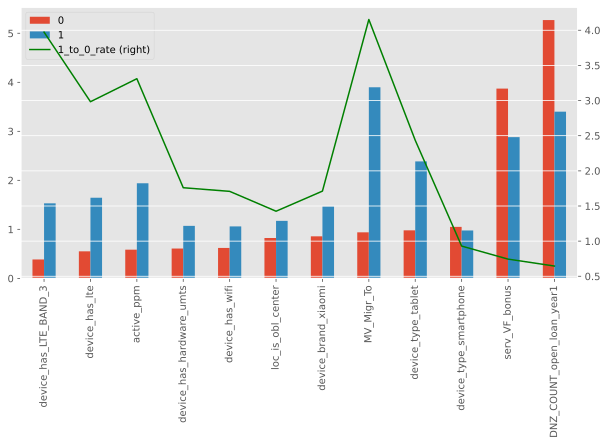

In [119]:
# at the same time with 'active_ppm' present the target seems to be bigger for all records in general
# let;s explore how the rest of the features influence traffic variance in general
# VISUALZING TARGET DIFFERENCE RATE FOR CATEGORICAL COLUMNS

var_by_cat_cols = pd.DataFrame(index=cat_col_list, 
                                  columns=['0', '1', '1_to_0_rate'])

for col in cat_col_list:
    temp = data_train.pivot_table(columns=col,values='var', aggfunc='median').fillna(0).applymap(float)
    var_by_cat_cols.loc[col]['0'] = temp[0].values[0]
    try:
        var_by_cat_cols.loc[col]['1'] = temp[1].values[0]
        var_by_cat_cols.loc[col]['1_to_0_rate'] = temp[1].values[0]/temp[0].values[0]
    except:
        var_by_cat_cols.loc[col]['1'] = np.nan
        var_by_cat_cols.loc[col]['1_to_0_rate'] = np.nan

    
del temp


ax1 = var_by_cat_cols.sort_values(by='0').loc[:, ['0', '1']].plot(kind = 'bar',
                                                                  figsize = (10,5),
                                                                  rot = 90,
                                                                  sharex = True)


ax1 = var_by_cat_cols.sort_values(by='0')['1_to_0_rate'].plot(secondary_y=True,
                                                              colormap = 'ocean',
                                                              rot = 90,
                                                              legend = True,
                                                              sharex = True);


In [121]:
# seems like MV_Migr_To, device_has_lte... and active_ppm considerably increase traffic variance, 
# while DNZ_COUNT_open_loan_year1 descreases it

var_by_cat_cols.sort_values(by='1_to_0_rate')

0         1 1_to_0_rate
DNZ_COUNT_open_loan_year1  5.269103   3.40111    0.645482
serv_VF_bonus              3.872156  2.881625    0.744191
device_type_smartphone     1.051497  0.977551    0.929675
loc_is_obl_center           0.82315  1.173412    1.425514
device_has_wifi            0.620704  1.060288    1.708204
device_brand_xiaomi        0.857963  1.468609     1.71174
device_has_hardware_umts   0.608529   1.07088    1.759784
device_type_tablet         0.980137  2.386187    2.434544
device_has_lte             0.551235  1.644589     2.98346
active_ppm                 0.586225  1.940818    3.310707
device_has_LTE_BAND_3      0.385379  1.531043    3.972822
MV_Migr_To                 0.938866  3.898848    4.152722

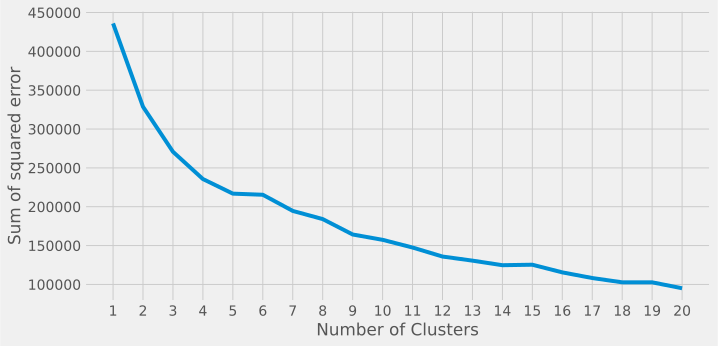

In [131]:
#Let's see if these categorical features form any meaningful groups 
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = data_train[cat_col_list].fillna(0)

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_train_big_var)
        sse.append(kmeans_batch.inertia_)
        
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [188]:
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = data_train[cat_col_list].fillna(0)
X_test_big_var = data_test[cat_col_list].fillna(0)

kmeans_batch = MiniBatchKMeans(n_clusters=9, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch_train = kmeans_batch.fit_predict(X_train_big_var)

y_kmeans_batch_test = kmeans_batch.predict(X_test_big_var)

data_train = data_train.assign(cluster = y_kmeans_batch_train)
data_test = data_test.assign(cluster = y_kmeans_batch_test)

del X_train_big_var, X_test_big_var,y_kmeans_batch_train,y_kmeans_batch_test


In [146]:
# CHECKING MULTICOLLENEARITY IN DATA

def highlight_corr_06_plus(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_high = s >= 0.6
    return ['background-color: red' if v else '' for v in is_high]

num_cols_to_use_wo_traffic = [x for x in num_cols_to_use if x not in traffic_cols]

collinear_cols_style = data_train_num_corr.loc[num_cols_to_use_wo_traffic, num_cols_to_use_wo_traffic].\
                                           style.apply(highlight_corr_06_plus).format("{:.2%}")


collinear_cols_style

In [147]:
data_train_num_corr.loc[num_cols_to_use_wo_traffic, num_cols_to_use_wo_traffic]['dpi_duration'].sort_values()

index
MV_ap_innet_out_v   -0.237959
MV_ARPU              0.149358
MV_Traf_4G_d_Mb      0.218169
MV_AP_total          0.224282
MV_ap_4G_d           0.237370
slope_traff          0.268099
dpi_day_cnt          0.297240
MV_Traf_3G_d_Mb      0.297962
MV_Traf_2G_d_Mb      0.336316
var_quant            0.413130
dpi_upload           0.468878
dpi_download         0.581810
dpi_events           0.742809
dpi_duration         1.000000
Name: dpi_duration, dtype: float64

In [148]:
data_train_num_corr.loc[num_cols_to_use_wo_traffic, num_cols_to_use_wo_traffic]['MV_ARPU'].sort_values()

index
MV_ap_innet_out_v   -0.040130
slope_traff          0.065802
MV_Traf_4G_d_Mb      0.143005
dpi_duration         0.149358
dpi_events           0.173819
dpi_upload           0.175152
dpi_download         0.224082
MV_Traf_2G_d_Mb      0.230181
dpi_day_cnt          0.244268
MV_Traf_3G_d_Mb      0.276610
var_quant            0.283333
MV_ap_4G_d           0.806980
MV_AP_total          0.836148
MV_ARPU              1.000000
Name: MV_ARPU, dtype: float64

In [149]:
totals_for_pca = ['MV_ARPU', 'MV_ap_4G_d', 'MV_AP_total']
dpi_for_pca = ['dpi_duration', 'dpi_upload', 'dpi_download', 'dpi_events']

In [151]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[totals_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[totals_for_pca].fillna(0))

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")


In [153]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[dpi_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[dpi_for_pca].fillna(0))

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")

In [155]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[totals_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[totals_for_pca].fillna(0))

pca_train = PCA(n_components = 1, random_state=3)
pca_test = PCA(n_components = 1, random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_test_std)



sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[dpi_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[dpi_for_pca].fillna(0))

pca_train = PCA(n_components = 2, random_state=3)
pca_test = PCA(n_components = 2, random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_test_std)


del(X_train_std, X_test_std)

In [204]:
generated_features = ['var','slope_traff', 'z_score_slope', 'big_slope','non_accum_internet_vol_td_mnt3_log',
                      'non_accum_internet_vol_td_mnt3_log_bins', 'big_var', 'cluster']

generated_features1 = ['var','slope_traff', 'z_score_slope', 'big_slope','non_accum_internet_vol_td_mnt3_log',
                       'big_var', 'cluster']


generated_features2 = ['var','slope_traff', 'cluster']

In [171]:
naiv_td_log_bins = pd.get_dummies(data_train['non_accum_internet_vol_td_mnt3_log_bins'])
cluster = pd.get_dummies(data_train['cluster'])

In [214]:
# cols_for_model = list(set(num_col_list + cat_col_list + generated_features1))
cols_for_model = list(set(num_cols_to_use + cat_col_list + generated_features1))
cols_for_model = list(set(num_cols_to_use + cat_col_list + generated_features2))
cols_for_model = num_cols_to_use

In [215]:
len(cols_for_model)

19

In [238]:
cols_for_model

['var_quant',
 'non_accum_internet_vol_std_mnt3',
 'dpi_download',
 'traff_m4',
 'MV_Traf_3G_d_Mb',
 'traff_m5',
 'dpi_events',
 'dpi_duration',
 'data_3g_tv_cnt_std_mnt1',
 'traff_m3',
 'slope_traff',
 'data_3g_tar_vol_std_mnt3',
 'all_cnt_mea_mnt3',
 'traff_m2',
 'MV_Traf_4G_d_Mb',
 'MV_ARPU',
 'MV_ap_4G_d',
 'content_cnt_mea_mnt3',
 'MV_ap_innet_out_v',
 'dpi_day_cnt',
 'gprs_tar_vol_std_mnt3',
 'dpi_upload',
 'MV_AP_total',
 'MV_Traf_2G_d_Mb',
 'traff_m1']

In [245]:
data_train_model = data_train[cols_for_model + ['target']].fillna(0)
data_test_model = data_test[cols_for_model + ['target']].fillna(0)

data_train_model = data_train_model.drop(totals_for_pca, axis=1)
data_train_model = data_train_model.drop(dpi_for_pca, axis=1)

data_train_model = data_train_model.assign(pca1=X_train_pca_totals[:, 0],
                                           pca2=X_train_pca_dpi[:, 0],
                                           pca3=X_train_pca_dpi[:, 1])


data_test_model = data_test_model.drop(totals_for_pca, axis=1)
data_test_model = data_test_model.drop(dpi_for_pca, axis=1)

data_test_model = data_test_model.assign(pca1=X_test_pca_totals[:, 0],
                                           pca2=X_test_pca_dpi[:, 0],
                                           pca3=X_test_pca_dpi[:, 1])

In [193]:
def df_normalization(df, cols_to_exclude = []):
    
    
    cols_to_use = list(df.columns)
   
    for col in cols_to_exclude:
        cols_to_use.remove(col)
        
    df_norm = df.copy()
    
    for column in cols_to_use: 
        df_norm[column] = (df_norm[column] - df_norm[column].min()) /(df_norm[column].max() - df_norm[column].min()) 

    return df_norm

In [246]:
X, y = data_train_model.loc[:, data_train_model.columns != 'target'], data_train_model.target

# X = df_normalization(X, [])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)


In [247]:
X_test_test, y_test_test = data_test_model.loc[:, data_test_model.columns != 'target'], data_test_model.target
# X_test_test = df_normalization(X_test_test, [])


In [232]:
new_cols = list(X_test_test.columns)

In [244]:
cols_for_model = ['slope_traff', 'traff_m1', 'traff_m2', 'traff_m3', 'traff_m5',
       'var_quant', 'dpi_duration', 'clc_no_vas_roam_std_mnt3', 'dpi_events',
       'dpi_day_cnt', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt1',
       'all_cnt_mea_mnt3', 'all_clc_std_mnt3', 'MV_ARPU', 'dpi_download',
       'dpi_upload', 'data_3g_tar_vol_std_mnt3',
       'non_accum_internet_vol_std_mnt3', 'gprs_tar_vol_std_mnt3',
       'MV_ap_4G_d', 'MV_ap_innet_out_v', 'MV_AP_total', 'MV_Traf_2G_d_Mb',
       'MV_Traf_3G_d_Mb', 'MV_Traf_4G_d_Mb']

In [227]:
old_cols = ['slope_traff', 'traff_m1', 'traff_m2', 'traff_m3', 'traff_m5',
       'var_quant', 'dpi_day_cnt', 'content_cnt_mea_mnt3',
       'data_3g_tv_cnt_std_mnt1', 'all_cnt_mea_mnt3',
       'data_3g_tar_vol_std_mnt3', 'non_accum_internet_vol_std_mnt3',
       'gprs_tar_vol_std_mnt3', 'MV_ap_innet_out_v', 'MV_Traf_2G_d_Mb',
       'MV_Traf_3G_d_Mb', 'MV_Traf_4G_d_Mb']

In [222]:
sorted(old_cols)

['MV_Traf_2G_d_Mb',
 'MV_Traf_3G_d_Mb',
 'MV_Traf_4G_d_Mb',
 'MV_ap_innet_out_v',
 'all_cnt_mea_mnt3',
 'content_cnt_mea_mnt3',
 'data_3g_tar_vol_std_mnt3',
 'data_3g_tv_cnt_std_mnt1',
 'dpi_day_cnt',
 'gprs_tar_vol_std_mnt3',
 'non_accum_internet_vol_std_mnt3',
 'pca1',
 'pca2',
 'pca3',
 'slope_traff',
 'traff_m1',
 'traff_m2',
 'traff_m3',
 'traff_m5',
 'var_quant']

In [224]:
sorted(new_cols)

['MV_AP_total',
 'MV_ARPU',
 'MV_Traf_2G_d_Mb',
 'MV_Traf_3G_d_Mb',
 'MV_Traf_4G_d_Mb',
 'MV_ap_4G_d',
 'MV_ap_innet_out_v',
 'dpi_day_cnt',
 'dpi_download',
 'dpi_duration',
 'dpi_events',
 'dpi_upload',
 'slope_traff',
 'traff_m1',
 'traff_m2',
 'traff_m3',
 'traff_m4',
 'traff_m5',
 'var_quant']

In [234]:
X_train.columns

Index(['var_quant', 'non_accum_internet_vol_std_mnt3', 'dpi_download',
       'traff_m4', 'MV_Traf_3G_d_Mb', 'traff_m5', 'dpi_events', 'dpi_duration',
       'data_3g_tv_cnt_std_mnt1', 'traff_m3', 'slope_traff',
       'data_3g_tar_vol_std_mnt3', 'all_cnt_mea_mnt3', 'traff_m2',
       'MV_Traf_4G_d_Mb', 'MV_ARPU', 'MV_ap_4G_d', 'content_cnt_mea_mnt3',
       'MV_ap_innet_out_v', 'dpi_day_cnt', 'gprs_tar_vol_std_mnt3',
       'dpi_upload', 'MV_AP_total', 'MV_Traf_2G_d_Mb', 'traff_m1'],
      dtype='object')

### MODELS

In [248]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_test_pred = model.predict(X_test_test)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train, y_train_pred, squared = False),
        mean_squared_error(y_test, y_test_pred, squared = False), 
        mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred),
        r2_score(y_test_test, y_test_test_pred)))

RMSE train: 7.738275, test: 8.476596, test_test: 8.719386
R^2 train: 0.575825, test: 0.488922, test_test:0.438522


In [249]:
y_test_test

index
0          0.001858
1          0.203970
2          0.267894
3         21.978195
4         28.489456
            ...    
243118     2.777133
243119     0.952221
243120     9.656545
243121    11.187644
243122    12.313563
Name: target, Length: 243123, dtype: float32

In [213]:
f_importance_df = pd.DataFrame(model.feature_importances_, X_train.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

importance
traff_m1                          263
traff_m5                          232
MV_Traf_4G_d_Mb                   199
traff_m4                          183
MV_Traf_3G_d_Mb                   180
traff_m3                          178
MV_ARPU                           177
MV_Traf_2G_d_Mb                   159
var                               157
slope_traff                       151
dpi_upload                        151
dpi_events                        147
dpi_duration                      137
traff_m2                           94
dpi_day_cnt                        86
MV_ap_4G_d                         81
dpi_download                       78
cluster                            75
MV_ap_innet_out_v                  60
MV_AP_total                        54
device_type_smartphone             24
loc_is_obl_center                  23
device_brand_xiaomi                18
device_has_wifi                    18
device_has_LTE_BAND_3              17
device_has_lte                     17
device_type_tablet                 12
device_has_hardware_umts           11
DNZ_COUNT_open_loan_year1           7
MV_Migr_To                          6
active_ppm                          5
serv_VF_bonus                       0
var_quant                           0

In [ ]:
n_folds = 5

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.05, 0.15, 0.20],
              'n_estimators': [100, 200, 300, 400],
              'reg_alpha':[0.05, 0.7, 0.8]}


lgbm = LGBMRegressor(silent=True, random_state= 3)

grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
res = grid_search.fit(X_train_full, y_train_full)


res


In [ ]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

In [ ]:
grid_search.cv_results_.get('mean_test_score')

In [ ]:
grid_search.cv_results_.get('params')[35]

In [ ]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0,
                          learning_rate = 0.05,
                          n_estimators = 200, 
                          reg_alpha = 0.7)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



In [ ]:
RMSE train: 7.706064, test: 8.513880, test_test: 7.957025
R^2 train: 0.562287, test: 0.462255, test_test:0.532413